In [0]:
%tensorflow_version 1.x

import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re, string
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer

from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping

In [0]:
#Create dataframe from csv data
df = pd.read_csv('export_dataframe.csv', error_bad_lines=False, na_values=['nan'])
text = df['Synopsis']
target = df['Summary']

In [12]:
#Create the dataframe we are working with and drop some nan rows
df = pd.DataFrame({'Synopsis':text, 'Summary':target}, dtype='str')

df=df[df.Summary != 'nan']
df

,Synopsis,Summary
0,The unforgettable novel of a childhood in a sl...,harper lee consid book simpl love story
1,"The year 1984 has come and gone, but George Or...",deni novel hold imagin generations power admon...
2,Alternate Cover Edition ISBN: 0743273567 (ISBN...,stori fabul wealthi jay gatsbi new love beauti...
3,Harry Potter's life is miserable. His parents ...,harri potter life miserable
4,George Orwell's timeless and timely allegorica...,anim farm published stalinist russia seen target
...,...,...
9996,Ballu is a gangster who is arrested by Inspec...,ram show compass ballu tri provid inform lead ...
9997,The central figure of the film is represented ...,scienc use brain art use brain heart
9998,"Set in 2003, Huck Cheever is a young and tale...",billi older sister suzann warn huck hustl 10 c...
9999,The Namesake depicts the struggles of Ashoke a...,short after gogol vacat maxin family ashok dies


In [0]:
#Method for cleaning the synopsis text data
def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\s+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([w for w in text.split() if w not in ENGLISH_STOP_WORDS])
    return text

df['Synopsis'] = df['Synopsis'].apply(clean_text)

In [14]:
#method for cleaning summary text data
def clean_title(title):
    title = str(title)
    title = title.lower()
    title = re.sub('\s+', ' ', title)
    title = title.translate(str.maketrans('', '', string.punctuation))
    title = ' '.join([w for w in title.split() if w not in ENGLISH_STOP_WORDS])
    return title

df['CleanTitle'] = df['Summary'].apply(clean_title)

#Here we add start and end to the targets so we know when the string stops and padding begins for later
df['CleanTitle'] = df['CleanTitle'].apply(lambda x : '_START_ '+ x + ' _END_')
print(df['CleanTitle'])

0        _START_ harper lee consid book simpl love stor...
1        _START_ deni novel hold imagin generations pow...
2        _START_ stori fabul wealthi jay gatsbi new lov...
3                _START_ harri potter life miserable _END_
4        _START_ anim farm published stalinist russia s...
                               ...                        
9996     _START_ ram compass ballu tri provid inform le...
9997     _START_ scienc use brain art use brain heart _...
9998     _START_ billi older sister suzann warn huck hu...
9999     _START_ short gogol vacat maxin family ashok d...
10000    _START_ practic line bathroom younger brother ...
Name: CleanTitle, Length: 9606, dtype: object


In [0]:
#Just train test split, test size of 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Synopsis'], df['CleanTitle'], test_size=0.2, random_state=0)

In [0]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(df['Synopsis'])

#Some globals required to maintain size for strings in and out of the model
max_text_length = 125
max_target_length = 20

#convert each sentence into an array of integer representations for the words
x_tr    =   x_tokenizer.texts_to_sequences(df['Synopsis']) 
x_val   =   x_tokenizer.texts_to_sequences(X_test)

#we are padding 0 here to the sequence so they are all the same size sequence
x_tr    =   sequence.pad_sequences(x_tr,  maxlen=max_text_length, padding='post') 
x_val   =   sequence.pad_sequences(x_val, maxlen=max_text_length, padding='post')

#Total number of different words in our X set
x_vocab_size   =  len(x_tokenizer.word_index) +1

#Repeat the same as above but in the Y set
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(df['CleanTitle'])
y_tr = y_tokenizer.texts_to_sequences(df['CleanTitle'])
y_val = y_tokenizer.texts_to_sequences(y_test)
y_tr = sequence.pad_sequences(y_tr, maxlen=max_target_length, padding='post')
y_val = sequence.pad_sequences(y_val, maxlen=max_target_length, padding='post')
y_vocab_size   =  len(y_tokenizer.word_index) +1

#Reshaping data to fit in the format that the RNN needs (3 Dimensions)
xtr = x_tr.reshape(x_tr.shape[0],x_tr.shape[1],1)
xval = x_val.reshape(x_val.shape[0],x_val.shape[1],1)
ytr = y_tr.reshape(y_tr.shape[0],y_tr.shape[1],1)
yval = y_val.reshape(y_val.shape[0],y_val.shape[1],1)

In [18]:
latentdim = 500
#Encoding input layer
enc_inputs = Input(shape=(max_text_length,))

#Encoding word embedding layer
enc_emb = Embedding(x_vocab_size, latentdim, trainable=True)

#Use the encoders embedding outputs as inputs for the encoding side LSTM
temp = enc_emb(enc_inputs)
enc_out, state_h, state_c = LSTM(latentdim,return_state=True,return_sequences=True)(temp)

enc_states = [state_h, state_c]
#enc_states are the states from the LSTM on enc side that we will use to decode and predict

In [0]:
#Decoding input layer
dec_inputs = Input(shape=(None,))
#Decoding word embedding layer
dec_emb = Embedding(y_vocab_size, latentdim, trainable=True)

#Same as in encoding we need to maintain the states so we pass the embedding layer into an LSTM
temp = dec_emb(dec_inputs)
dec_lstm = LSTM(latentdim, return_sequences=True, return_state=True)

dec_out, dec_state_h, dec_stat_c = dec_lstm(temp,initial_state=enc_states) #encoder states used here

#Dense layer to turn our matrix into a usable output array
dec_dense = Dense(y_vocab_size, activation='softmax')
dec_out = dec_dense(dec_out)

In [22]:
#Creating the model object with a printout to help visualize the connections
model = Model([enc_inputs,dec_inputs], dec_out)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 125)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 125, 500)     48361500    input_2[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 500)    18539000    input_4[0][0]                    
__________________________________________________________________________________________

In [25]:
#Training the model, batch_size and epochs can be adjusted for your environment and were selected through trial and error.
# epochs is the number of times the models is trained on the data
# batch_size is the number of rows fed to the model at a time, higher batch_size requires more memory but will train faster
modelout = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Train on 9606 samples, validate on 1922 samples
Epoch 1/50
9606/9606 [==============================] - 54s 6ms/step - loss: 6.0268 - val_loss: 5.8621
Epoch 2/50
9606/9606 [==============================] - 54s 6ms/step - loss: 5.9066 - val_loss: 5.7856
Epoch 3/50
9606/9606 [==============================] - 55s 6ms/step - loss: 5.8244 - val_loss: 5.7264
Epoch 4/50
9606/9606 [==============================] - 55s 6ms/step - loss: 5.7407 - val_loss: 5.5902
Epoch 5/50
9606/9606 [==============================] - 55s 6ms/step - loss: 5.6344 - val_loss: 5.4739
Epoch 6/50
9606/9606 [==============================] - 55s 6ms/step - loss: 5.5351 - val_loss: 5.3848
Epoch 7/50
9606/9606 [==============================] - 55s 6ms/step - loss: 5.4359 - val_loss: 5.2493
Epoch 8/50
9606/9606 [==============================] - 55s 6ms/step - loss: 5.3349 - val_loss: 5.1550
Epoch 9/50
9606/9606 [==============================] - 55s 6ms/step - loss: 5.2314 - val_loss: 5.0340
Epoch 10/50
9606/9606 [==

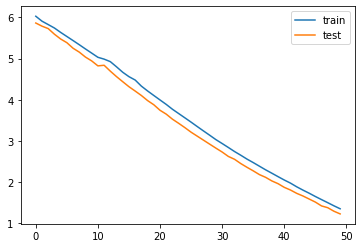

In [27]:
#Visualization of models performance over # of epochs
from matplotlib import pyplot 
pyplot.plot(modelout.history['loss'], label='train') 
pyplot.plot(modelout.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [0]:
#Save the model for use in our demo and to prevent us from having to train every time which can take a long time
import os
os.makedirs('./model', exist_ok=True)
model.save('./model/model.h5')